In [1]:
import numpy as np
import numpy.random as nrd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, LogisticRegression

from collections import defaultdict

# Exercise 16.4

Program and run the simulation study described in Figure 16.2, whose caption is as follow,

Simulations that show the superiority of the L1 (lasso) penalty
over L2 (ridge) in regression and classification. Each run has 50 observations
with 300 independent Gaussian predictors. In the top row all 300 coefficients are
nonzero, generated from a Gaussian distribution. In the middle row, only 10 are
nonzero, and the last row has 30 nonzero. Gaussian errors are added to the linear
predictor η(X) for the regression problems, and binary responses generated via the
inverse-logit transform for the classification problems. Scaling of η(X) resulted in
the noise-to-signal ratios shown. Lasso is used in the left sub-columns, ridge in the
right. We report the optimal percentage of error explained on test data (relative
to the error of a constant model), displayed as boxplots over 20 realizations for
each combination. In the only situation where ridge beats lasso (top row), neither
do well.

# Solution

Below are some useful functions,

In [2]:
# random number generator
rng = nrd.default_rng(seed=140590)

# Generate Nxp predictors normally distributed
def predictors(N,p,rng):
    return rng.normal(size=(N,p))

# Generate p coefficients normally distributed (only p_nonzero of them are != 0)
def coefficients(p,p_nonzero,rng):
    
    theta = np.zeros(p)
    theta[:p_nonzero] = rng.normal(size=p_nonzero)
    
    return theta

# Generate the regression respone y from the predictors, with scaling
# alpha achieving a given noise-to-signal treshold
def response_regression(X,theta,nsr,rng):
    
    N,_ = X.shape
    
    # Shrinkage for Noise-to-Signal ratio (regression)
    alpha = 1/np.sqrt(nsr * theta @ theta)
    
    # Response
    y = alpha * X @ theta + rng.normal(size=N)
    
    return y,alpha

# Check the noise-to-signal treshold for regression
def nsr_regression(X,theta,alpha,y):
    return np.var(y - alpha * X @ theta)/np.var(alpha * X @ theta)
    
# Inverse logit transformation
def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

# Generate the classification respone y from the predictors, with scaling
# alpha achieving a given noise-to-signal treshold
def response_classification(X,theta,nsr,rng):
    
    N,_ = X.shape
    
    # Shrinkage for Noise-to-Signal ratio (classification)
    alpha = 1/np.sqrt(4* nsr * theta @ theta)
    
    # Response
    y = inv_logit(alpha * X @ theta + rng.normal(size=N)) > 1/2
        
    return y, alpha

# Check the noise-to-signal treshold for classification
def nsr_classification(X,theta,alpha,y):
    return np.var(y)/np.var(alpha * X @ theta)

### Noise-to-signal ratio

Let's check that we are generating responses with the correct noise-to-signal ratio,

In [3]:
N = 1000 # Number of observation
p = 300  # Number of predictors
K = 100  # Number of different datasets

# The noise-to-signal ratio we want to achive
nsr = 0.5
print('The noise-to-signal ratio we aim to achieve = {}'.format(nsr))

theta = coefficients(p,p,rng)

# Regression response
estimated_nsr = []
for _ in range(K):
    
    X = predictors(N,p,rng)
    y, alpha = response_regression(X,theta,nsr,rng)
    estimated_nsr.append(nsr_regression(X,theta,alpha,y))

nsr_est = np.mean(estimated_nsr)
nsr_se = np.std(estimated_nsr)/np.sqrt(K)

print('The noise-to-signal ratio for regression = {:.4f} (SE {:.4f})'.format(nsr_est,nsr_se))

# Classification response
estimated_nsr = []
for _ in range(K):
    
    X = predictors(N,p,rng)
    y, alpha = response_classification(X,theta,nsr,rng)
    estimated_nsr.append(nsr_classification(X,theta,alpha,y))

nsr_est = np.mean(estimated_nsr)
nsr_se = np.std(estimated_nsr)/np.sqrt(K)

print('The noise-to-signal ratio for classification = {:.4f} (SE {:.4f})'.format(nsr_est,nsr_se))

The noise-to-signal ratio we aim to achieve = 0.5
The noise-to-signal ratio for regression = 0.4969 (SE 0.0031)
The noise-to-signal ratio for classification = 0.5025 (SE 0.0022)


### Regression and classification analysis

We compare the performance of lasso and ridge in high-dimensional input spaces, for both regression and classification

In [4]:
# Parameters for the training
N_train = 50
p = 300
K = 20

# Test set
N_test = 5000
X_test = predictors(N_test,p,rng)

# We consider responses with/without sparsity, and with different noise-to-signal ratios
p_nonzero = [300,10,30]
noise_to_signal = [0.1,0.2,0.3,0.4,0.5]

# The regularisation parameters for lasso and ridge (different for regression and classification)
reg_parameters = [1e-4 * 10**(4*k/50) for k in range(50)]
clas_parameters = [1e-3 * 10**(6*k/50) for k in range(50)]

R_square_lasso = defaultdict(list)
R_square_ridge = defaultdict(list)
misclassification_lasso = defaultdict(list)
misclassification_ridge = defaultdict(list)

# First we construct different coefficients, some are sparse, some are dense
for pnz in p_nonzero:
    theta = coefficients(p,pnz,rng)
    
    # Here we construct the test response for different noise-to-signal ratios
    for nsr in noise_to_signal:
        y_test_reg, _ = response_regression(X_test,theta,nsr,rng)
        y_test_clas, _ = response_classification(X_test,theta,nsr,rng)
        
        # for each sparsity/NSR we make K sample of the predictors/response RVs
        for _ in range(K):
            
            # Preparing the input+response for regression and classification
            X_train = predictors(N_train,p,rng)
            y_train_reg, _ = response_regression(X_train,theta,nsr,rng)
            y_train_clas, _ = response_classification(X_train,theta,nsr,rng)
            
            ## Regression
            score_lasso = []
            score_ridge = []
            
            for reg in reg_parameters:
                
                # Fitting the data with Lasso, computing R square on test data
                model_lasso = Lasso(alpha=reg,max_iter=7000)
                model_lasso.fit(X_train, y_train_reg)
                score_lasso.append(model_lasso.score(X_test,y_test_reg))
                
                # Fitting the data with Ridge, computing R square on test data
                model_ridge = Ridge(alpha=(2*N)*reg,max_iter=7000) # 2N due to loss ridge != lasso
                model_ridge.fit(X_train, y_train_reg)
                score_ridge.append(model_ridge.score(X_test,y_test_reg))
                
            R_square_lasso[(pnz,nsr)].append(max(score_lasso))
            R_square_ridge[(pnz,nsr)].append(max(score_ridge))
                
            ## Classification
            score_lasso = []
            score_ridge = []
            
            for reg in clas_parameters:
                
                model_lasso = LogisticRegression(penalty='l1', C=1e2*reg, max_iter=1000,
                                                 solver='liblinear')
                model_lasso.fit(X_train, y_train_clas)
                score_lasso.append(model_lasso.score(X_test,y_test_clas))
                
                model_ridge = LogisticRegression(penalty='l2', C=reg, max_iter=1000,
                                                 solver='liblinear')
                model_ridge.fit(X_train, y_train_clas)
                score_ridge.append(model_ridge.score(X_test,y_test_clas))
                
            misclassification_lasso[(pnz,nsr)].append(1-2*(1-max(score_lasso)))
            misclassification_ridge[(pnz,nsr)].append(1-2*(1-max(score_ridge)))
            
        print('Simulation for sparsity = {:.2f} and NSR = {:.1f} done'.format(1-pnz/p,nsr))

Simulation for sparsity = 0.00 and NSR = 0.1 done
Simulation for sparsity = 0.00 and NSR = 0.2 done
Simulation for sparsity = 0.00 and NSR = 0.3 done
Simulation for sparsity = 0.00 and NSR = 0.4 done
Simulation for sparsity = 0.00 and NSR = 0.5 done
Simulation for sparsity = 0.97 and NSR = 0.1 done
Simulation for sparsity = 0.97 and NSR = 0.2 done
Simulation for sparsity = 0.97 and NSR = 0.3 done
Simulation for sparsity = 0.97 and NSR = 0.4 done
Simulation for sparsity = 0.97 and NSR = 0.5 done
Simulation for sparsity = 0.90 and NSR = 0.1 done
Simulation for sparsity = 0.90 and NSR = 0.2 done
Simulation for sparsity = 0.90 and NSR = 0.3 done
Simulation for sparsity = 0.90 and NSR = 0.4 done
Simulation for sparsity = 0.90 and NSR = 0.5 done


### Regression performance

Let's see how Lasso and Ridge compare to each others with dense/sparse data and low/high noise-to-signal ratios, in regression tasks.

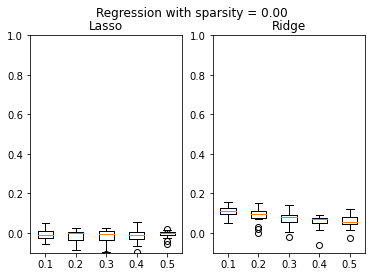

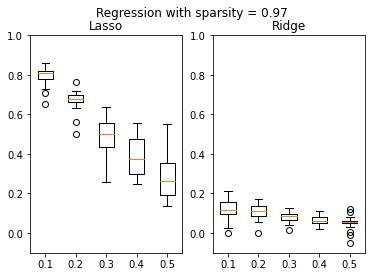

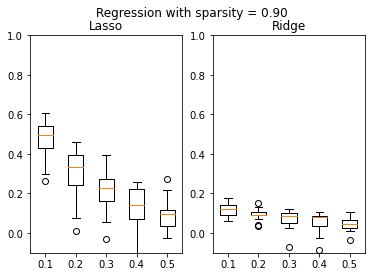

In [5]:
for pnz in p_nonzero:
    
    data_lasso = [R_square_lasso[(pnz,nsr)] for nsr in noise_to_signal]
    data_ridge = [R_square_ridge[(pnz,nsr)] for nsr in noise_to_signal]
    
    plt.suptitle('Regression with sparsity = {:.2f}'.format(1-pnz/p))
    
    plt.subplot(1,2,1)
    plt.boxplot(data_lasso,labels=noise_to_signal)
    plt.title('Lasso')
    plt.ylim((-0.1,1.0))
                 
    plt.subplot(1,2,2)
    plt.boxplot(data_ridge,labels=noise_to_signal)
    plt.title('Ridge')
    plt.ylim((-0.1,1.0))
    plt.show()

### Regression performance

Let's see how Lasso and Ridge compare to each others with dense/sparse data and low/high noise-to-signal ratios, in classification tasks.

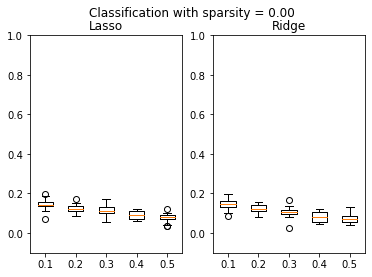

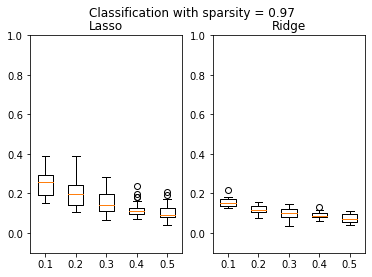

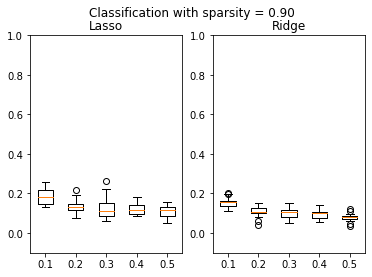

In [7]:
for pnz in p_nonzero:
    
    data_lasso = [misclassification_lasso[(pnz,nsr)] for nsr in noise_to_signal]
    data_ridge = [misclassification_ridge[(pnz,nsr)] for nsr in noise_to_signal]
    
    plt.suptitle('Classification with sparsity = {:.2f}'.format(1-pnz/p))
    
    plt.subplot(1,2,1)
    plt.boxplot(data_lasso,labels=noise_to_signal)
    plt.title('Lasso')
    plt.ylim((-0.1,1.0))
                 
    plt.subplot(1,2,2)
    plt.boxplot(data_ridge,labels=noise_to_signal)
    plt.title('Ridge')
    plt.ylim((-0.1,1.0))
    plt.show()